# paper
[Input shaping Control of an Overhead Crane](https://www.researchgate.net/publication/301619730_Input_shaping_Control_of_an_Overhead_Crane)

[LIMITING HIGH MODE VIBRATION AND RISE TIME IN FLEXIBLE TELEROBOTIC
ARMS](https://www.researchgate.net/publication/255579642_LIMITING_HIGH_MODE_VIBRATION_AND_RISE_TIME_IN_FLEXIBLE_TELEROBOTIC_ARMS)

# Percentage Vibration( not h(t) )
$V(\omega_n, \xi) = e^{-\xi \omega_n t_n} \sqrt{C(\omega_n, \xi)^2 + S(\omega_n, \xi)^2}$ 

$C(\omega_n, \xi) = \sum_{i=1}^n A_i e^{\xi \omega_n t_i}cos(\omega_d t_i)$  

$S(\omega_n, \xi) = \sum_{i=1}^n A_i e^{\xi \omega_n t_i}sin(\omega_d t_i)$

$\omega_d = \omega_n\sqrt{1-\xi^2}$

# h(t) is
$y_0(t) = \Bigg[ \frac{A_0\omega_n}{\sqrt{1-\xi^2}}e^{-\xi\omega_n(t-t_0)} \Bigg] sin\big(\omega_n\sqrt{1-\xi^2}(t-t_0) \big)$



In [7]:
from scipy.signal import convolve

class PercentageVibration:
    M = 20
    m = 0.8
    g = 9.81
    l = 1
    xi = 0.00358
    omega_n = np.sqrt((M + m)*g/(M*l))
    num = 100
    Ai = np.ones((num,))/num
    ti = np.linspace(0, 1, num)
    omega_d = omega_n*np.sqrt(1 - xi**2)
   
    def V(self, tn):
        return np.exp(-self.xi*self.omega_n*tn)*np.sqrt(self.C()**2 + self.S()**2)
    
    def C(self):
        return sum(self.Ai*np.exp(self.xi*self.omega_n*self.ti)*np.cos(self.omega_d*self.ti))
    
    def S(self):
        return sum(self.Ai*np.exp(self.xi*self.omega_n*self.ti)*np.sin(self.omega_d*self.ti))

class UnitImpulseResponse:
    M = 20
    m = 0.8
    g = 9.81
    l = 1
    xi = 0.00358
    omega_n = np.sqrt((M + m)*g/(M*l))
    omega_d = omega_n*np.sqrt(1 - xi**2)
    A0 = 1
    t0 = 0
    Td = 2*np.pi/omega_d
    
    def y(self, t):
        first = (self.A0*self.omega_n)/(np.sqrt(1- self.xi**2))*np.exp(-self.xi*self.omega_n*(t - self.t0))
        second = np.sin(self.omega_d*(t - self.t0))
        return first*second

class IIR:
    """
    iir = IIR()
    ys = iir_result_adjusted = iir.ys(a)
    # this not working since u(k) is mean to be the velovity, not the response
    # we need other tools to verify that this kind of filter does indeed work 
    plt.plot(t, ys)
    """
    M = 20
    m = 0.8
    g = 9.81
    l = 1
    xi = 0.00358
    omega_n = np.sqrt((M + m)*g/(M*l))
    omega_d = omega_n*np.sqrt(1 - xi**2)
    Td = 2*np.pi/omega_d
    sigma = 0.1
    A = (omega_n/sigma)**2
    B = (sigma**2 - omega_n**2)/(sigma**2)
    C = (2*xi*omega_n*sigma - omega_n**2 - sigma**2)/sigma
    a1 = -2*np.exp(-sigma*Td)
    a2 = np.exp(-2*sigma*Td)
    b0 = (sigma/omega_n)**2
    b1 = ((sigma/omega_n)**2)*(-B + (-2*A - B + C*Td)*np.exp(-sigma*Td))
    b2 = ((sigma/omega_n)**2)*((B - C*Td)*np.exp(-sigma*Td) + A*np.exp(-2*sigma*Td))
    u_prev1 = 0
    u_prev2 = 0
    y_prev1 = 0
    y_prev2 = 0
    
    def difference_equation(self, u_curr):
        # u, I think is system input like velocity, not the response
        # how can we apply the transform function to the response?
        # in FIR, we can apply the convolution to both input and response to see what happened since
        # convolution is indeed a impulse addition process
        "$y(k) = -a_1y(k-1) - a_2y(k-2) + b_0u(k) + b_1u(k-1) + b_2u(k-2)$"
        y_curr = -self.a1 * self.y_prev1 - self.a2 * self.y_prev2 + self.b0 * u_curr + self.b1 * self.u_prev1 + self.b2 * self.u_prev2
        self.u_prev2 = self.u_prev1
        self.u_prev1 = u_curr
        self.y_prev2 = self.y_prev1
        self.y_prev1 = y_curr
        return y_curr
    
    def ys(self, us):
        return [self.difference_equation(u) for u in us]

def convolve_y(x, y, kernel):
    impulse_input = np.zeros_like(x)
    impulse_time = kernel['time']
    impulse_magnitude = kernel['value']
    for imp_time, imp_mag in zip(impulse_time, impulse_magnitude):
        impulse_input[np.argmin(np.abs(x - imp_time))] = imp_mag
    y_c = convolve(y, impulse_input, mode='full')
    return y_c

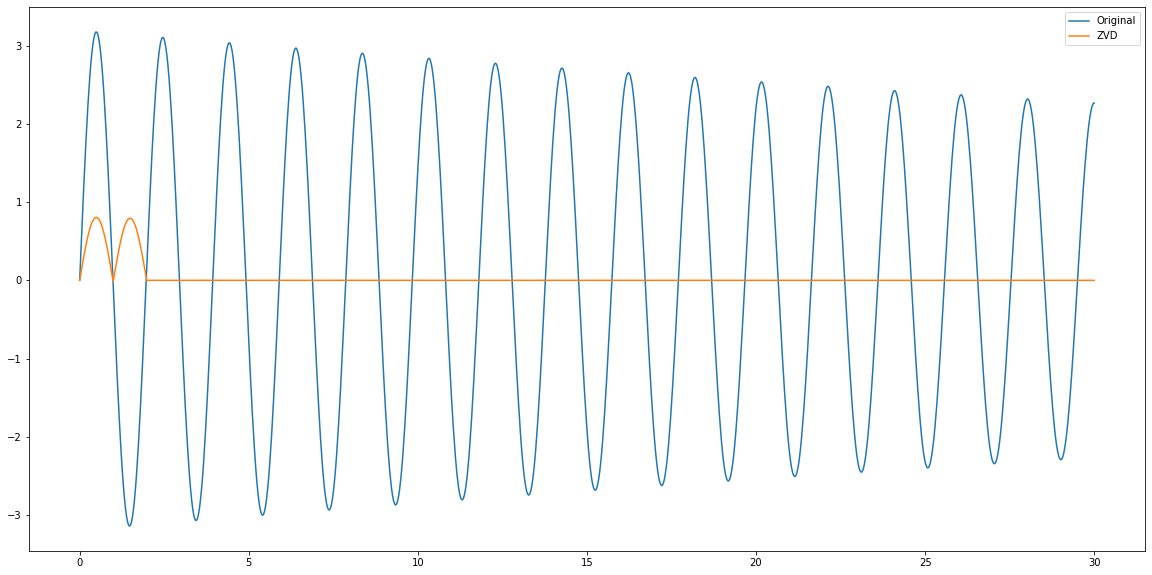

In [34]:
# original response
impulse = UnitImpulseResponse()
t = np.linspace(0, 30, 1000)  
y = impulse.y(t)
plt.plot(t, y, label="Original")

# zv
# kernel = dict(time=[0, 0.5*impulse.Td], value=[0.503, 0.497])
# y_c = convolve_y(t, y, kernel)
# plt.plot(t, y_c[:1000], label="ZV")

# zvd
kernel = dict(time=np.array([0, 0.5*impulse.Td, impulse.Td])+0.,  value=[0.253, 0.5, 0.247])
y_c = convolve_y(t, y, kernel)
plt.plot(t, y_c[:1000], label="ZVD")

plt.legend()


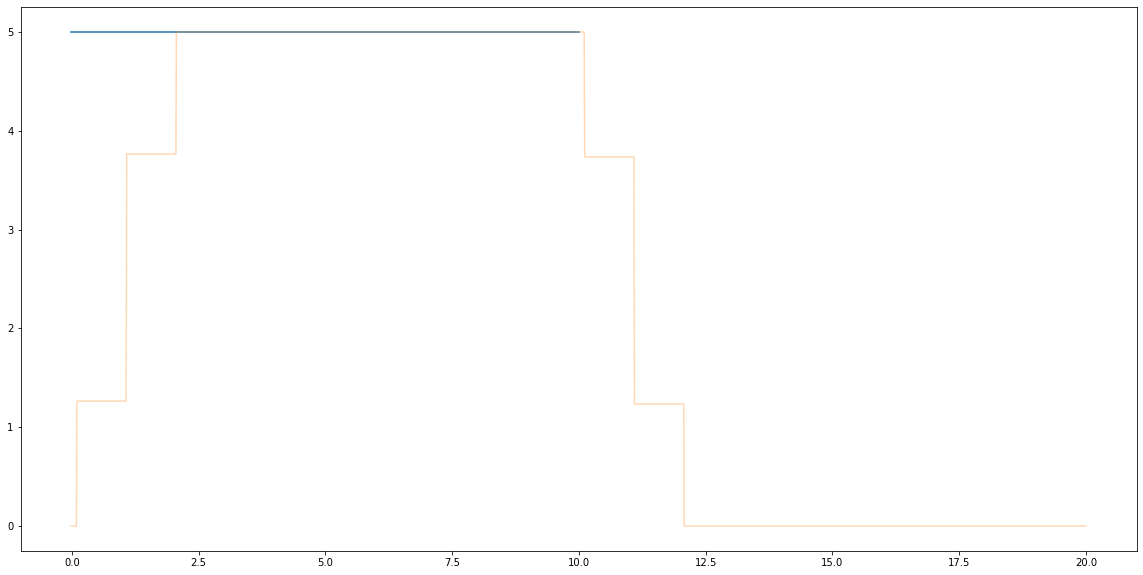

In [22]:
# original velocity
t1 = np.linspace(-0.01, 10, 1000)  
t2 = np.linspace(-0.01, 20, 1999)  

velocity = np.full_like(t1, 5)
plt.plot(t1, velocity) 

# kernel = dict(time=[0, 0.5*impulse.Td], value=[0.503, 0.497])
# v_c = convolve_y(t1, velocity, kernel)
# plt.plot(t2, v_c, label="ZV-Speed")

kernel = dict(time=np.array([0, 0.5*impulse.Td, impulse.Td])+0.1, value=[0.253, 0.5, 0.247])
v_c = convolve_y(t1, velocity, kernel)
plt.plot(t2, v_c, label="ZVD-Speed", alpha=0.3)




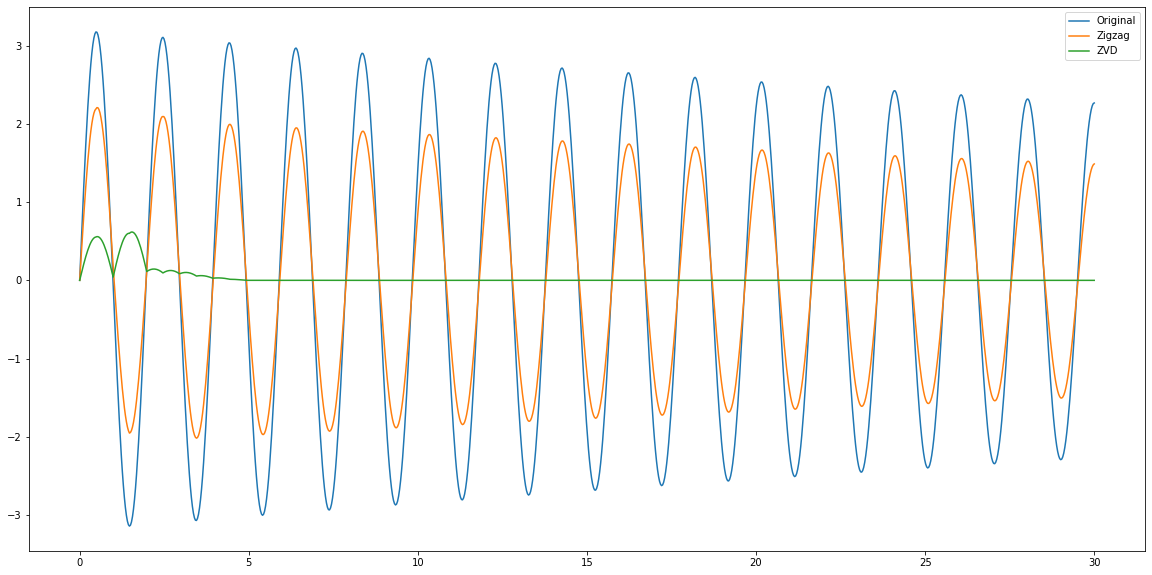

In [9]:
# original response
impulse = UnitImpulseResponse()
t = np.linspace(0, 30, 1000)  
y = impulse.y(t)
plt.plot(t, y, label="Original")

# zv
# kernel = dict(time=[0, 0.5*impulse.Td], value=[0.503, 0.497])
# y_c = convolve_y(t, y, kernel)
# plt.plot(t, y_c[:1000], label="ZV")

# zvd
kernel = dict(time=np.array([0, 0.5, 1, 1.5, 2, 2.5, 3])*Td, value=np.array([10, 1, 1, 1, 0.75, 0.5, 0.25])/14.5)
y_c = convolve_y(t, y, kernel)
kernel = dict(time=[0, 0.5*impulse.Td, impulse.Td], value=[0.253, 0.5, 0.247])
y_c2 = convolve_y(t, y_c, kernel)
plt.plot(t, y_c[:1000], label="Zigzag")
plt.plot(t, y_c2[:1000], label="ZVD")

plt.legend()


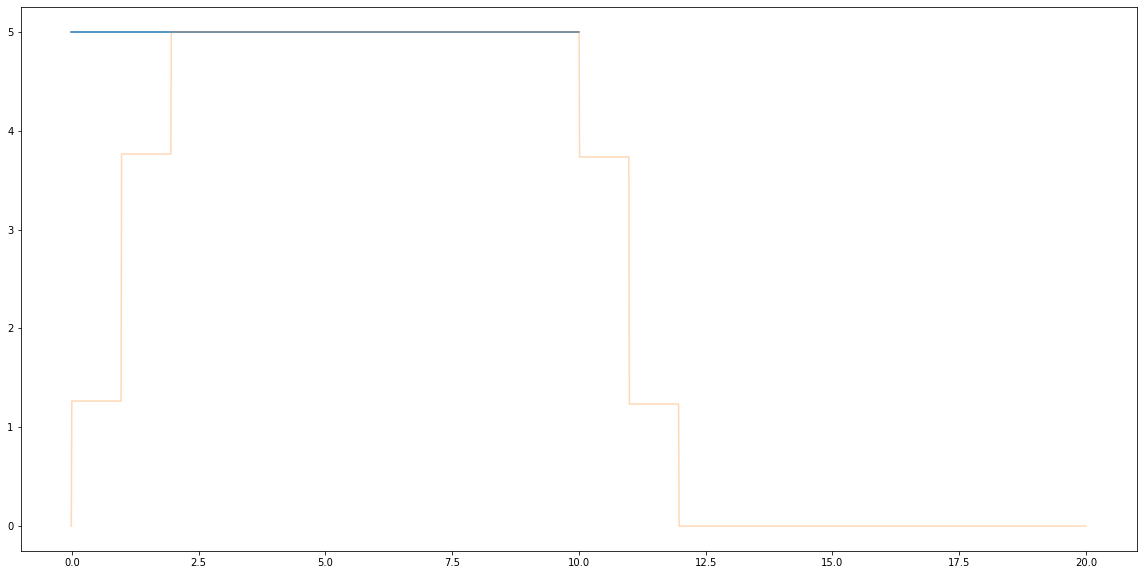

In [17]:
# original velocity
t1 = np.linspace(-0.01, 10, 1000)  
t2 = np.linspace(-0.01, 20, 1999)  

velocity = np.full_like(t1, 5)
plt.plot(t1, velocity) 

# kernel = dict(time=[0, 0.5*impulse.Td], value=[0.503, 0.497])
# v_c = convolve_y(t1, velocity, kernel)
# plt.plot(t2, v_c, label="ZV-Speed")

kernel = dict(time=[0, 0.5*impulse.Td, impulse.Td], value=[0.253, 0.5, 0.247])
v_c = convolve_y(t1, velocity, kernel)
plt.plot(t2, v_c, label="ZVD-Speed", alpha=0.3)




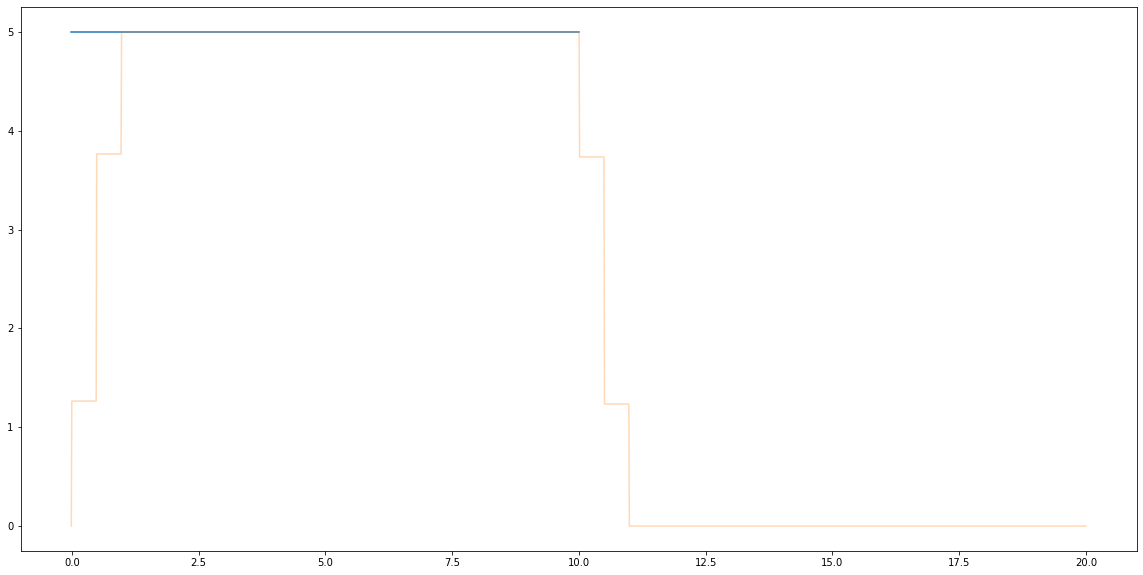

In [1]:
from scipy.signal import convolve
from matplotlib import pyplot as plt
import numpy as np

def convolve_y(x, y, kernel):
    impulse_input = np.zeros_like(x)
    impulse_time = kernel['time']
    impulse_magnitude = kernel['value']
    for imp_time, imp_mag in zip(impulse_time, impulse_magnitude):
        impulse_input[np.argmin(np.abs(x - imp_time))] = imp_mag
    y_c = convolve(y, impulse_input, mode='full')
    return y_c

# original velocity
t1 = np.linspace(-0.01, 10, 1000)  
t2 = np.linspace(-0.01, 20, 1999)  
velocity = np.full_like(t1, 5)
plt.plot(t1, velocity) 

# the convoluted velocity given kernel
Td = 0.98
kernel = dict(time=[0, 0.5*Td, Td], value=[0.253, 0.5, 0.247])
v_c = convolve_y(t1, velocity, kernel)
plt.plot(t2, v_c, label="ZVD-Speed", alpha=0.3)




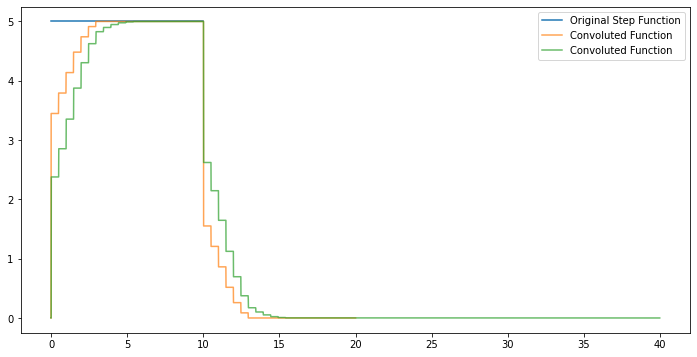

In [2]:
from scipy.signal import convolve
from matplotlib import pyplot as plt
import numpy as np

# Define the convolution function as provided by the user
def convolve_y(x, y, kernel):
    impulse_input = np.zeros_like(x)
    impulse_time = kernel['time']
    impulse_magnitude = kernel['value']
    for imp_time, imp_mag in zip(impulse_time, impulse_magnitude):
        impulse_input[np.argmin(np.abs(x - imp_time))] = imp_mag
    y_c = convolve(y, impulse_input, mode='full')
    return y_c

# Define the original function and kernel
t1 = np.linspace(-0.01, 10, 1000)  
t2 = np.linspace(-0.01, 20, 1999)
t3 = np.linspace(-0.01, 40, 3999)  

velocity = np.full_like(t1, 5)
Td = 0.98
# Kernel that needs to be found to match the desired output shape
# Here, we hypothesize a kernel with a sharp rise and a gradual decay
kernel = dict(time=np.array([0, 0.5, 1, 1.5, 2, 2.5, 3])*Td, value=np.array([10, 1, 1, 1, 0.75, 0.5, 0.25])/14.5)
# Convolve and plot the original and convoluted velocity
v_c = convolve_y(t1, velocity, kernel)
v_c2 = convolve_y(t2, v_c, kernel)
plt.figure(figsize=(12, 6))
plt.plot(t1, velocity, label="Original Step Function")
plt.plot(t2[:len(v_c)], v_c, label="Convoluted Function", alpha=0.7)
plt.plot(t3[:len(v_c2)], v_c2, label="Convoluted Function", alpha=0.7)

plt.legend()
plt.show()


In [8]:
len(v_c)

1999

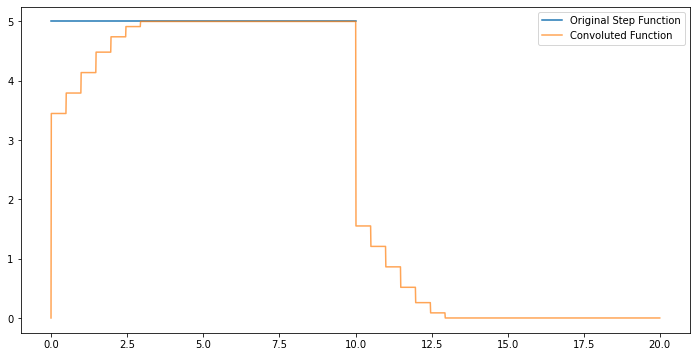

In [6]:
from scipy.signal import convolve
from matplotlib import pyplot as plt
import numpy as np

# Define the convolution function as provided by the user
def convolve_y(x, y, kernel):
    impulse_input = np.zeros_like(x)
    impulse_time = kernel['time']
    impulse_magnitude = kernel['value']
    for imp_time, imp_mag in zip(impulse_time, impulse_magnitude):
        impulse_input[np.argmin(np.abs(x - imp_time))] = imp_mag
    y_c = convolve(y, impulse_input, mode='full')
    return y_c

# Define the original function and kernel
t1 = np.linspace(-0.01, 10, 1000)  
t2 = np.linspace(-0.01, 20, 1999)  
velocity = np.full_like(t1, 5)

# Kernel that needs to be found to match the desired output shape
# Here, we hypothesize a kernel with a sharp rise and a gradual decay
kernel = dict(time=np.array([0, 0.5, 1, 1.5, 2, 2.5, 3])*Td, value=np.array([10, 1, 1, 1, 0.75, 0.5, 0.25])/14.5)
# Convolve and plot the original and convoluted velocity
v_c = convolve_y(t1, velocity, kernel)
plt.figure(figsize=(12, 6))
plt.plot(t1, velocity, label="Original Step Function")
plt.plot(t2[:len(v_c)], v_c, label="Convoluted Function", alpha=0.7)
plt.legend()
plt.show()
